In [1]:
import numpy as np

import torch
import torch.nn as nn

from tqdm import tqdm

from IPython.display import clear_output

import matplotlib.pyplot as plt

In [2]:
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = "".join([x.replace('\t\t', '').lower() for x in text])

In [3]:
SOS_TOKEN = '<sos>'
tokens = sorted(set(text.lower())) + [SOS_TOKEN]

num_tokens = len(tokens)

print(f"num_tokens: {num_tokens}")

token_to_index = {token : index for index, token in enumerate(tokens)}
index_to_token = {index : token for index, token in enumerate(tokens)}

num_tokens: 84


In [4]:
text_indices = [token_to_index[token] for token in text]

In [5]:
def get_random_chunk(batch_size, seq_length):
    text_len = len(text)
    # start_index in [0, text_len - seq_length - 1]
    start_indices = np.random.randint(low=0, high=text_len - seq_length, size=batch_size)
    random_chunks = [[token_to_index[SOS_TOKEN]] + text_indices[start_index:start_index + seq_length] for start_index in start_indices]
    random_chunks = np.array(random_chunks)
    assert random_chunks.shape == (batch_size, seq_length + 1)
    return random_chunks

In [6]:
def assert_check_shapes(lhs_shape, rhs_shape):
    assertion_message = f"Not equal shapes: {lhs_shape} instead of {rhs_shape}"
    assert lhs_shape == rhs_shape, assertion_message

In [7]:
class RNNCell(nn.Module):
    def __init__(self, num_tokens, embedding_size, hidden_embedding_size):
        super(self.__class__, self).__init__()
        self.num_tokens = num_tokens
        self.embedding_size = embedding_size
        self.hidden_embedding_size = hidden_embedding_size

        self.embedding_layer = nn.Embedding(num_embeddings=num_tokens, embedding_dim=embedding_size)

        # input shape:              (batch_size, 1)
        # with embeds shape:        (batch_size, embedding_size)
        # last hidden state shape:  (batch_size, hidden_embedding_size)
        self.W_to_new_hidden = nn.Linear(embedding_size + hidden_embedding_size, hidden_embedding_size)
        self.W_to_raw_logits = nn.Linear(hidden_embedding_size, num_tokens)

    def forward(self, input, last_hidden_state):
        batch_size = input.shape[0]

        # (batch, embedding_size)
        input_embeddings = self.embedding_layer(input).squeeze(dim=1)
        assert_check_shapes(
            input_embeddings.shape, 
            (batch_size, self.embedding_size)
        )

        # (batch, embedding_size + hidden_embedding_size)
        concat_input_and_last_hidden = torch.cat([input_embeddings, last_hidden_state], dim=-1)
        assert_check_shapes(
            concat_input_and_last_hidden.shape, 
            (batch_size, self.embedding_size + self.hidden_embedding_size)
        )

        # (batch, hidden_embedding_size)
        new_hidden_state = self.W_to_new_hidden(concat_input_and_last_hidden)
        assert_check_shapes(
            new_hidden_state.shape, (batch_size, self.hidden_embedding_size)
        )

        # (batch, num_tokens)
        raw_logits = self.W_to_raw_logits(new_hidden_state)
        assert_check_shapes(
            raw_logits.shape, 
            (batch_size, self.num_tokens)
        )

        return {
            'raw_logits' : raw_logits,
            'hidden_state' : new_hidden_state
        }
    
    def get_start_state(self, batch_size):
        return torch.zeros(batch_size, self.hidden_embedding_size, requires_grad=True)

In [8]:
def rnn_loop(rnn_cell, batch_indices):
    batch_size = batch_indices.shape[0]
    seq_length = batch_indices.shape[1] - 1
    
    last_hidden_state = rnn_cell.get_start_state(batch_size)
    
    all_logits = []
    true_tokens = []

    for i in range(0, seq_length + 1):
        input = torch.LongTensor(batch_indices[:, i]).unsqueeze(dim=-1)
        assert input.shape == (batch_size, 1)
        output = rnn_cell(input, last_hidden_state)
        
        all_logits.append(output['raw_logits'])
        true_tokens.append(input)

        last_hidden_state = output['hidden_state']

    stacked_logits = torch.stack(all_logits, dim=1)
    assert_check_shapes(
        stacked_logits.shape, 
        (batch_size, seq_length + 1, num_tokens)
    )

    stacked_true_tokens = torch.stack(true_tokens, dim=-1).squeeze(dim=1)
    assert_check_shapes(
        stacked_true_tokens.shape,
        (batch_size, seq_length + 1)
    )
    
    return {
        'stacked_logits' : stacked_logits,
        'true_tokens' : stacked_true_tokens
    }

In [12]:
def train(
    num_tokens, 
    seq_length,
    embedding_size, 
    hidden_embedding_size, 
    batch_size=8,
    epochs=1000
):
    rnn_cell = RNNCell(
        num_tokens=num_tokens,
        embedding_size=embedding_size,
        hidden_embedding_size=hidden_embedding_size
    )

    loss_func = nn.CrossEntropyLoss()
    optimizer = opt = torch.optim.Adam(rnn_cell.parameters())

    loss_history = []
    
    for epoch in tqdm(range(epochs), desc='Iterating batches...'):
        opt.zero_grad()
        batch_indices = get_random_chunk(seq_length=seq_length, batch_size=batch_size)
        output = rnn_loop(rnn_cell=rnn_cell, batch_indices=batch_indices)

        stacked_logits = output['stacked_logits']
        true_tokens = output['true_tokens']

        stacked_logits_flat = torch.flatten(stacked_logits[:, 1:, :], end_dim=1)
   
        actual_next_tokens = torch.LongTensor(batch_indices[:, 1:].flatten())

        loss = loss_func(stacked_logits_flat, actual_next_tokens)

        loss.backward()
        optimizer.step()

        if (epoch + 1) % 1 == 0:
            loss_history.append(loss.data)
            
    plt.plot(loss_history, label="loss")
    plt.legend()
    plt.show()
            
    return rnn_cell

In [13]:
embedding_size = 16
hidden_embedding_size = 32
batch_size = 16
seq_length = 30
assert num_tokens == len(tokens)

Iterating batches...: 100%|██████████| 1000/1000 [00:03<00:00, 275.24it/s]


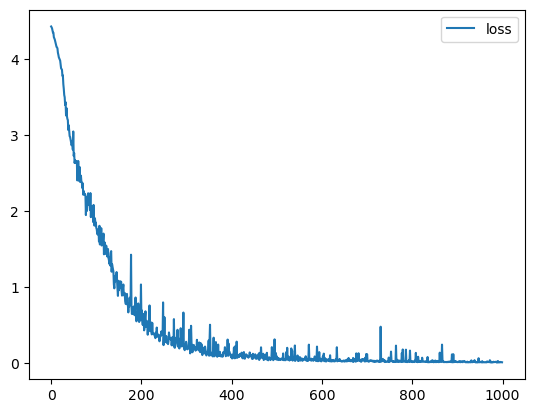

In [14]:
trained_rnn_cell = train(
    num_tokens=num_tokens,
    seq_length=seq_length,
    embedding_size=embedding_size,
    hidden_embedding_size=hidden_embedding_size,
    batch_size=batch_size,
    epochs=1000
)